## Demo: 2D super-resolution on mouse brain cortex images
This notebook demonstrates applying a EMDiffuse-n model for a 2D denoising task, assuming that training was already completed via training.ipynb. You can also download the [model weight](https://connecthkuhk-my.sharepoint.com/personal/u3590540_connect_hku_hk/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fu3590540%5Fconnect%5Fhku%5Fhk%2FDocuments%2FEMDiffuse%5Fmodel%5Fweight%2FEMDiffuse%2Dr) trained on mouse brain cortex super-resolution dataset. 

The trained model is assumed to be located in the folder ``experiments`` with the name EMDiffuse-n. 
The example image is stored in demo/super_res_demo.tif.

The diffusion process is relatively slow on CPU. So it is recommended to run prediction on GPU. 

In [ ]:
!git clone https://github.com/Luchixiang/EMDiffuse
%cd EMDiffuse/
!pip install warmup_scheduler

Run the following line if you run the notebook on local computer after clone the github repository. Igore it if you run the notebook on google colab.

In [4]:
# %cd ../..

/Users/luchixiang/Downloads/hku/phd/EMDiffuse


In [5]:
import core.praser as Praser
import os
import warnings
import torch
import torch.multiprocessing as mp
from tifffile import imread
from crop_single_file import crop
from core.logger import VisualWriter, InfoLogger
import core.praser as Praser
import core.util as Util
from data import define_dataloader
from models import create_EMDiffuse
from emdiffuse_conifg import EMDiffuseConfig
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/luchixiang/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Crop the image
Due to the GPU memeory limitation, we need to crop the large images into patches.

In [6]:
img = imread('./demo/super-res-demo.tif')
plt.imshow(img, cmap='gray')
crop_save_path = os.path.join('./demo', 'super_res_crop_patches', 'cell_1', 'noise_1')
os.makedirs(crop_save_path, exist_ok=True)
crop(img, crop_save_path, patch_size=128, stride=112)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/luchixiang/Downloads/hku/phd/EMDiffuse/demo/super-res-demo.tif'

## Show example cropped data

Text(0.5, 1.0, 'Example 2')

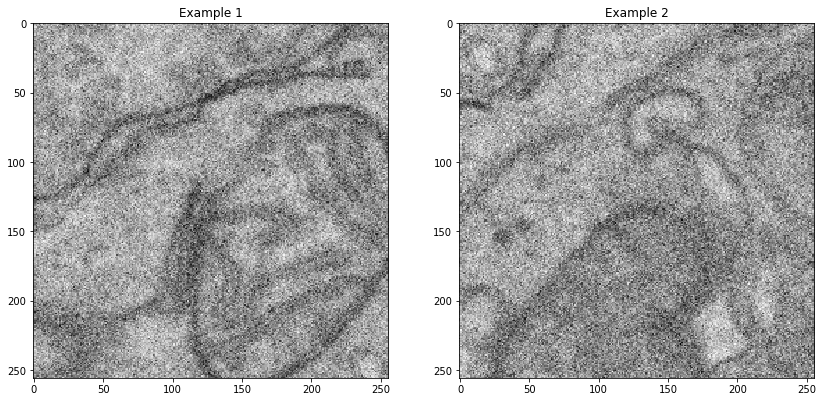

In [3]:
example_image_noise1 = imread(os.path.join(crop_save_path, '2_0.tif'))
example_image_noise2 = imread(os.path.join(crop_save_path, '3_1.tif'))
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(example_image_noise1, cmap='gray')
plt.title('Example 1')
plt.subplot(1,2,2)
plt.imshow(example_image_noise2, cmap='gray')
plt.title('Example 2')

In [ ]:
import urllib
import zipfile
if not os.path.isdir('./experiments'):
    os.mkdir('./experiments')

# Download the model weight trained on mouse brain cortex denoise dataset, skip this step if you prefer to use trained model.
zipPath="experiments/EMDiffuse-n.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://zenodo.org/records/10663405/files/EMDiffuse-n.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("experiments")

## EMDiffuse-r model
Load the trained model (located in experients with name my_model) from disk.
The configuration file was same as training. 

batch size: test batch size on every gpu.

mean: Diffusion model samples one plausible solution from the learned solution distribution. Mean denotes the number of outputs you want to generate and average. 

resume: The model weight path and the epoch number to load


In [7]:
config = EMDiffuseConfig(config='config/EMDiffuse-n.json', phase='test', 
                         path='./demo/denoise_crop_patches', batch_size=16, mean=1, resume='./experiments/EMDiffuse-n/2720')
opt = Praser.parse(config) # Parse the config
opt['world_size'] = 1 
Util.set_seed(opt['seed'])
print(opt['distributed'])
model = create_EMDiffuse(opt)
print(f'len test data loader: {len(model.phase_loader)}')

False
{'data_root': './demo/denoise_crop_patches', 'norm': True, 'percent': False, 'phase': 'val'}
in dataset: ./demo/denoise_crop_patches
val
network norm: True
len test data loader: 13


## Test the model

The results and logger information will be saved in a new folder `./experiments/test_EMDiffuse-n_time/results` where time is the current time. If you find the results are total noise image, it is mostly likely because you didn't load the model weight properly.

In [9]:
model.test()

KeyboardInterrupt: 

## Show some super-resolution results

In [ ]:
results_path = './experiments/xxx/results/test/0' # you should replace the results path with your own folder name
noisy_images = glob.glob(os.path.join(results_path, 'Input_*.tif'))
if len(noise_images) != 0:
    for i in range(3):
        noisy_img =  imread(noisy_images[i])
        gt_img = imread(noisy_images[i].replace('Input', 'Output'))
        plt.figure(figsize=(14,7))
        plt.subplot(1,2,1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title('Low-resolution')
        plt.subplot(1,2,2)
        plt.imshow(gt_img, cmap='gray')
        plt.title('Predicted')